# The covariance test

One of the first works in this framework of post-selection
inference is the [covariance test](http://arxiv.org/abs/1301.7161).
The test was motivated by a drop in covariance of the residual 
through one step of the [LARS path](http://projecteuclid.org/DPubS?verb=Display&version=1.0&service=UI&handle=euclid.aos/1083178935&page=record). 

The basic theory behind the `covtest` can be seen by sampling $n$ IID
Gaussians and looking at the spacings between the top two.
A simple calculation Mills' ratio calculation leads to
$$
Z^n_{(1)} (Z^n_{(1)} - Z^n_{(2)}) \overset{D}{\to} \text{Exp}(1)
$$
Here is a little simulation.

In [1]:
import numpy as np
np.random.seed(0)
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.distributions import ECDF
from selectinf.algorithms.covtest import covtest


We will sample 2000 times from $Z \sim N(0,I_{50 \times 50})$ and look at the normalized spacing between the top 2 values.



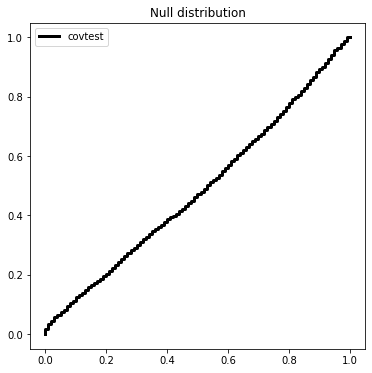

In [2]:
Z = np.random.standard_normal((2000,50))
T = np.zeros(2000)
for i in range(2000):
    W = np.sort(Z[i])
    T[i] = W[-1] * (W[-1] - W[-2])

Ugrid = np.linspace(0,1,101)
covtest_fig = plt.figure(figsize=(6,6))
ax = covtest_fig.gca()
ax.plot(Ugrid, ECDF(np.exp(-T))(Ugrid), drawstyle='steps', c='k',
        label='covtest', linewidth=3)
ax.set_title('Null distribution')
ax.legend(loc='upper left');

The covariance test is an asymptotic result, and can be used
in a sequential procedure called [forward stop](http://arxiv.org/abs/1309.5352) to determine when to
stop the LASSO path.

An exact version of the covariance test was developed
in a general framework for problems beyond the LASSO  using
the [Kac-Rice formula](http://arxiv.org/abs/1308.3020).
A sequential version along the LARS path was developed,
which we refer to as the [spacings test](http://arxiv.org/abs/1401.3889).

Here is the exact test, which is the first step of the spacings test.

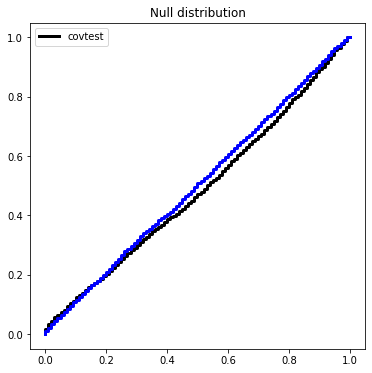

In [3]:
from scipy.stats import norm as ndist
Texact = np.zeros(2000)
for i in range(2000):
    W = np.sort(Z[i])
    Texact[i] = ndist.sf(W[-1]) / ndist.sf(W[-2])
ax.plot(Ugrid, ECDF(Texact)(Ugrid), c='blue', drawstyle='steps', label='exact covTest',
        linewidth=3)
covtest_fig

## Covariance test for regression

The above tests were based on an IID sample, though
both the `covtest` and its exact version can be used
in a regression setting. Both tests need access to the covariance
of the noise.

Formally, suppose 
$$
y|X \sim N(\mu, \Sigma)
$$
the exact test is a test of 
$$H_0:\mu=0.$$

The test is based on 
$$
\lambda_{\max} = \|X^Ty\|_{\infty}.
$$

This value of $\lambda$ is the value at which the first variable enters the LASSO. That is, $\lambda_{\max}$ is the smallest 
$\lambda$ for which 0 solves
$$
\text{minimize}_{\beta} \frac{1}{2} \|y-X\beta\|^2_2 + \lambda \|\beta\|_1.
$$

Formally, the exact test conditions on the variable $i^*(y)$ that achieves $\lambda_{\max}$ and tests a weaker null hypothesis 
$$H_0:X[:,i^*(y)]^T\mu=0.$$ The covtest is 
an approximation of this test, based on the same Mills ratio
calculation. (This calculation roughly says that the overshoot of a Gaussian above a level $u$ is roughly an exponential random variable with mean $u^{-1}$).

Here is a simulation under $\Sigma = \sigma^2 I$ with $\sigma$ known.
The design matrix, before standardization, is Gaussian equicorrelated in the population with parameter 1/2.

In [4]:
n, p, nsim, sigma = 50, 200, 1000, 1.5

def instance(n, p, beta=None, sigma=sigma):
    X = (np.random.standard_normal((n,p)) + np.random.standard_normal(n)[:,None])
    X /= X.std(0)[None,:]
    X /= np.sqrt(n)
    Y = np.random.standard_normal(n) * sigma
    if beta is not None:
        Y += np.dot(X, beta)
    return X, Y 

Let's make a dataset under our global null and compute the
exact covtest $p$-value.

In [5]:
X, Y = instance(n, p, sigma=sigma) 
cone, pval, idx, sign = covtest(X, Y, exact=False)
pval

0.06488988967797554

The object `cone` is an instance of `selection.affine.constraints` which does much of the work for affine selection procedures.
The variables `idx` and `sign` store which variable achieved
$\lambda_{\max}$ and the sign of its correlation with $y$.

In [6]:
cone

In [7]:
def simulation(beta):
    Pcov = []
    Pexact = []

    for i in range(nsim):
        X, Y = instance(n, p, sigma=sigma, beta=beta)
        Pcov.append(covtest(X, Y, sigma=sigma, exact=False)[1])
        Pexact.append(covtest(X, Y, sigma=sigma, exact=True)[1])

    Ugrid = np.linspace(0,1,101)
    plt.figure(figsize=(6,6))
    plt.plot(Ugrid, ECDF(Pcov)(Ugrid), label='covtest', ds='steps', c='k', linewidth=3)
    plt.plot(Ugrid, ECDF(Pexact)(Ugrid), label='exact covtest', ds='steps', c='blue', linewidth=3)
    plt.legend(loc='lower right')


## Null

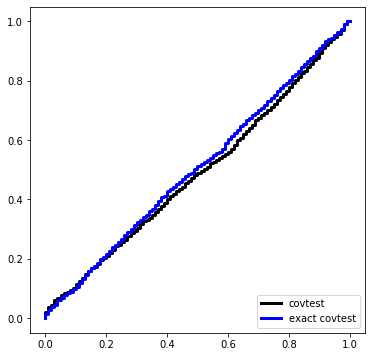

In [8]:
beta = np.zeros(p)
simulation(beta)

## 1-sparse

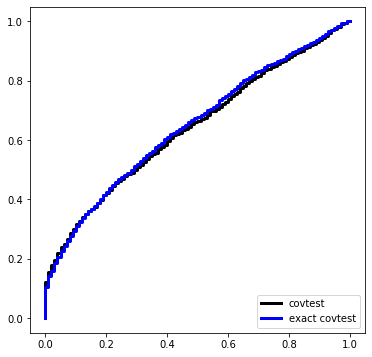

In [9]:
beta = np.zeros(p)
beta[0] = 4
simulation(beta)
 

## 2-sparse

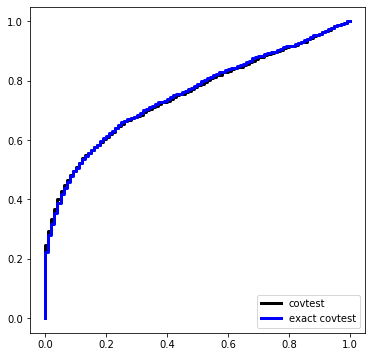

In [10]:
beta = np.zeros(p)
beta[:2] = 4
simulation(beta)
 

## 5-sparse

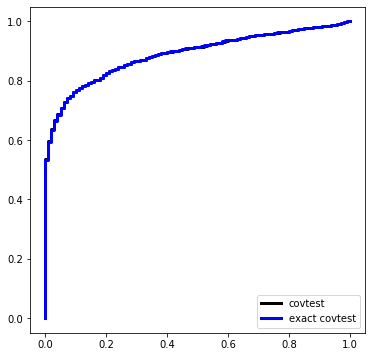

In [11]:
beta = np.zeros(p)
beta[:5] = 4
simulation(beta)
 